# Bank Marketing Dataset

# CGAN Training for synthesize datasets


CGAN: A conditional generative adversarial network (CGAN) is a type of GAN that also takes advantage of labels during the training process. Generator — Given a label and random array as input, this network generates data with the same structure as the training data observations corresponding to the same label.

Then, we save the CGAN models for the data generation pipeline.

In [138]:
# TODO
# try also https://github.com/sdv-dev/CTGAN

## Imports

In [2]:
import os
import pandas as pd
import numpy as np
from ydata_synthetic.synthesizers.regular import CGAN
from ydata_synthetic.synthesizers import ModelParameters, TrainParameters
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from src.pipeline.data_generation.data_generator import GANDataGenerator
from src.pipeline.datasets.training_datasets import BankMarketingDataset, BankMarketingProcessedDataset
from src.pipeline.model.paths import BANK_MARKETING_GEN_CGAN_MODEL_PATH


2021-12-25 13:37:01.589694: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reading the Datasets

# Load Preprocessed Data

# EDA and Preprocessing

In [4]:
# init GANDataGenerator
print('Bank Marketing dataset\n')
origin_dataset = BankMarketingProcessedDataset()
origin_dataset = BankMarketingDataset()

df = origin_dataset.raw_df
label_col = origin_dataset.label_column_name

df.head()
df.shape

print(f'Label columns name is: {label_col}. With {df[label_col].nunique()} unique values.'
      f'({df[label_col].unique()})')


Bank Marketing dataset

loading dataset
loading dataset


/home/user/code/data_drift_detctor/src/pipeline/config.py:21: UnsafeLoaderWarning: 
The default 'Loader' for 'load(stream)' without further arguments can be unsafe.
Use 'load(stream, Loader=ruamel.yaml.Loader)' explicitly if that is OK.
Alternatively include the following in your code:

  import warnings
  warnings.simplefilter('ignore', ruamel.yaml.error.UnsafeLoaderWarning)

In most other cases you should consider using 'safe_load(stream)'
  cfg = ryaml.load(f)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


(4521, 17)

Label columns name is: y. With 2 unique values.(['no' 'yes'])


In [8]:
train_sample = df.sample(4521)

In [9]:
cat_cols = [col for col in df.columns if any(cat_col for cat_col in origin_dataset.categorical_feature_names if cat_col + '_' in col)]
numeric_cols = [col for col in df.columns if any(numeric_col for numeric_col in origin_dataset.numeric_feature_names if numeric_col in col)]

cat_cols = origin_dataset.categorical_feature_names
numeric_cols = origin_dataset.numeric_feature_names

# numeric_cols.remove('job_management')

# assert len(cat_cols)+len(numeric_cols) == len(df.columns)


# Init the GAN

In [10]:

to_save = False

#Define the Conditional GAN and training parameters

noise_dim = 32
dim = 128
batch_size = 128
beta_1 = 0.5
beta_2 = 0.9

log_step = 100
epochs = 500 + 1
learning_rate = 5e-4


gan_args = ModelParameters(batch_size=batch_size,
                           lr=learning_rate,
                           betas=(beta_1, beta_2),
                           noise_dim=noise_dim,
                           n_cols=train_sample.shape[1] - 1,  # Don't count the label columns here
                           layers_dim=dim)

train_args = TrainParameters(epochs=epochs,
                             cache_prefix='',
                             sample_interval=log_step,
                             label_dim=-1,
                             labels=[0,1])

num_classes = df[label_col].nunique()

#Init the Conditional GAN providing the index of the label column as one of the arguments
synthesizer = CGAN(model_parameters=gan_args, num_classes=num_classes)




2021-12-25 13:37:57.148014: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-25 13:37:57.148934: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-12-25 13:37:57.177079: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2021-12-25 13:37:57.177111: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: data-science-l-danielle
2021-12-25 13:37:57.177119: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: data-science-l-danielle
2021-12-25 13:37:57.177216: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.86.0
2021-12-25 13:37:57.177240: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.86.0
2021-12-25 13:37:57.177246: I tensorflow/stream_execut

# Training


In [11]:
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder

class LabelProcessor:
    def __init__(self, dataset):
        self._df = dataset._raw_df
        self._label_col = dataset.label_column_name
        self._cat_cols = dataset.categorical_feature_names
        self._numeric_cols = dataset.numeric_feature_names
        self._processed_df = None
        self._encoder = None

    def preprocessed_data(self):
        df = self._df
        label_col = self._label_col
        cat_cols = self._cat_cols + [label_col]
        numeric_cols = self._numeric_cols

        columns = df.columns

        df_cat_cols = df[cat_cols]
        df_numeric_cols = df[numeric_cols]

        encoder_dict = defaultdict(LabelEncoder)
        df_cat_cols_processed = df_cat_cols.apply(lambda x: encoder_dict[x.name].fit_transform(x))

        df_processed = pd.concat([df_numeric_cols, df_cat_cols_processed], axis=1)
        df_processed = df_processed[columns]

        self._encoder = encoder_dict
        self._processed_df = df_processed

    def postprocess_data(self):
        encoder_dict = self._encoder
        cat_cols = self._cat_cols + [self._label_col]
        inverse_transform_lambda = lambda x: encoder_dict[x.name].inverse_transform(x) if x.name in cat_cols else x
        return self._processed_df.apply(inverse_transform_lambda)

    def encoder_dict(self):
        np.save('label_encoder_dict.npy', self._encoder)

    def load_encoder_dict(self):
        np.load('label_encoder_dict.npy')


In [12]:
processor = LabelProcessor(origin_dataset)
processor.preprocessed_data()
processor.postprocess_data()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,services,married,secondary,no,-333,yes,no,cellular,30,jul,329,5,-1,0,unknown,no
4517,57,self-employed,married,tertiary,yes,-3313,yes,yes,unknown,9,may,153,1,-1,0,unknown,no
4518,57,technician,married,secondary,no,295,no,no,cellular,19,aug,151,11,-1,0,unknown,no
4519,28,blue-collar,married,secondary,no,1137,no,no,cellular,6,feb,129,4,211,3,other,no


In [13]:
train_sample = processor._processed_df
train_sample

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,10,1,0,0,1787,0,0,0,19,10,79,1,-1,0,3,0
1,33,7,1,1,0,4789,1,1,0,11,8,220,1,339,4,0,0
2,35,4,2,2,0,1350,1,0,0,16,0,185,1,330,1,0,0
3,30,4,1,2,0,1476,1,1,2,3,6,199,4,-1,0,3,0
4,59,1,1,1,0,0,1,0,2,5,8,226,1,-1,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,7,1,1,0,-333,1,0,0,30,5,329,5,-1,0,3,0
4517,57,6,1,2,1,-3313,1,1,2,9,8,153,1,-1,0,3,0
4518,57,9,1,1,0,295,0,0,0,19,1,151,11,-1,0,3,0
4519,28,1,1,1,0,1137,0,0,0,6,3,129,4,211,3,1,0


In [14]:
#----------------------------
#    GAN Training
#----------------------------

#Training the Conditional GAN
synthesizer.train(data=train_sample, label_col=label_col, train_arguments=train_args,
                 num_cols=numeric_cols, cat_cols=cat_cols )

#Saving the synthesizer
if to_save:
    synthesizer.save(BANK_MARKETING_GEN_CGAN_MODEL_PATH)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-12-25 13:38:25.297280: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-25 13:38:25.298097: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-25 13:38:25.736722: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-12-25 13:38:25.755531: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2699905000 Hz
  0%|          | 0/501 [00:00<?, ?it/s]

0 [D loss: 0.353012, acc.: 92.19%] [G loss: 1.631232]



  0%|          | 2/501 [00:10<41:53,  5.04s/it]

1 [D loss: 0.150957, acc.: 94.92%] [G loss: 3.837918]


  1%|          | 3/501 [00:14<38:10,  4.60s/it]

2 [D loss: 0.119095, acc.: 96.09%] [G loss: 6.659198]


  1%|          | 4/501 [00:18<36:46,  4.44s/it]

3 [D loss: 0.088249, acc.: 98.83%] [G loss: 7.671537]


  1%|          | 5/501 [00:22<36:09,  4.37s/it]

4 [D loss: 0.074982, acc.: 97.66%] [G loss: 9.433075]


  1%|          | 6/501 [00:27<35:59,  4.36s/it]

5 [D loss: 0.080337, acc.: 97.27%] [G loss: 13.099222]


  1%|▏         | 7/501 [00:31<35:32,  4.32s/it]

6 [D loss: 0.052111, acc.: 99.22%] [G loss: 16.395565]


  2%|▏         | 8/501 [00:35<35:00,  4.26s/it]

7 [D loss: 0.042592, acc.: 98.83%] [G loss: 16.788689]


  2%|▏         | 9/501 [00:39<34:23,  4.19s/it]

8 [D loss: 0.018626, acc.: 99.61%] [G loss: 20.225281]


  2%|▏         | 10/501 [00:43<33:56,  4.15s/it]

9 [D loss: 0.017907, acc.: 98.83%] [G loss: 20.290829]


  2%|▏         | 11/501 [00:48<34:53,  4.27s/it]

10 [D loss: 0.080564, acc.: 98.05%] [G loss: 23.089340]


  2%|▏         | 12/501 [00:52<34:43,  4.26s/it]

11 [D loss: 0.027665, acc.: 99.61%] [G loss: 24.010509]


  3%|▎         | 13/501 [00:56<34:32,  4.25s/it]

12 [D loss: 0.040884, acc.: 98.83%] [G loss: 23.635811]


  3%|▎         | 14/501 [01:00<34:03,  4.20s/it]

13 [D loss: 0.032286, acc.: 99.61%] [G loss: 26.960510]


  3%|▎         | 15/501 [01:04<33:42,  4.16s/it]

14 [D loss: 0.064653, acc.: 98.44%] [G loss: 30.650524]


  3%|▎         | 16/501 [01:09<33:27,  4.14s/it]

15 [D loss: 0.014218, acc.: 99.61%] [G loss: 34.294937]


  3%|▎         | 17/501 [01:13<33:16,  4.12s/it]

16 [D loss: 0.003879, acc.: 100.00%] [G loss: 30.754589]


  4%|▎         | 18/501 [01:17<33:24,  4.15s/it]

17 [D loss: 0.002918, acc.: 100.00%] [G loss: 33.366726]


  4%|▍         | 19/501 [01:21<32:35,  4.06s/it]

18 [D loss: 0.006248, acc.: 99.61%] [G loss: 36.320236]


  4%|▍         | 20/501 [01:24<31:14,  3.90s/it]

19 [D loss: 0.002073, acc.: 100.00%] [G loss: 34.689949]


  4%|▍         | 21/501 [01:28<30:14,  3.78s/it]

20 [D loss: 0.009736, acc.: 99.61%] [G loss: 39.452862]


  4%|▍         | 22/501 [01:31<30:01,  3.76s/it]

21 [D loss: 0.001370, acc.: 100.00%] [G loss: 38.592964]


  5%|▍         | 23/501 [01:35<30:03,  3.77s/it]

22 [D loss: 0.006782, acc.: 100.00%] [G loss: 36.295624]


  5%|▍         | 24/501 [01:39<30:10,  3.79s/it]

23 [D loss: 0.023331, acc.: 99.61%] [G loss: 42.046310]


  5%|▍         | 25/501 [01:43<29:29,  3.72s/it]

24 [D loss: 0.001329, acc.: 100.00%] [G loss: 37.338314]


  5%|▌         | 26/501 [01:46<29:12,  3.69s/it]

25 [D loss: 0.002679, acc.: 100.00%] [G loss: 42.859692]


  5%|▌         | 27/501 [01:50<29:00,  3.67s/it]

26 [D loss: 0.010975, acc.: 99.61%] [G loss: 52.423347]


  6%|▌         | 28/501 [01:54<28:52,  3.66s/it]

27 [D loss: 0.004112, acc.: 100.00%] [G loss: 51.490524]


  6%|▌         | 29/501 [01:57<28:37,  3.64s/it]

28 [D loss: 0.001068, acc.: 100.00%] [G loss: 48.967499]


  6%|▌         | 30/501 [02:01<28:20,  3.61s/it]

29 [D loss: 0.002239, acc.: 100.00%] [G loss: 52.498230]


  6%|▌         | 31/501 [02:04<28:10,  3.60s/it]

30 [D loss: 0.001130, acc.: 100.00%] [G loss: 57.678024]


  6%|▋         | 32/501 [02:08<28:52,  3.69s/it]

31 [D loss: 0.016327, acc.: 99.61%] [G loss: 58.804848]


  7%|▋         | 33/501 [02:12<28:46,  3.69s/it]

32 [D loss: 0.000973, acc.: 100.00%] [G loss: 56.068298]


  7%|▋         | 34/501 [02:15<28:25,  3.65s/it]

33 [D loss: 0.000606, acc.: 100.00%] [G loss: 61.470314]


  7%|▋         | 35/501 [02:19<28:00,  3.61s/it]

34 [D loss: 0.000430, acc.: 100.00%] [G loss: 61.084312]


  7%|▋         | 36/501 [02:22<27:55,  3.60s/it]

35 [D loss: 0.001809, acc.: 100.00%] [G loss: 70.376556]


  7%|▋         | 37/501 [02:26<28:12,  3.65s/it]

36 [D loss: 0.007506, acc.: 99.61%] [G loss: 69.096985]


  8%|▊         | 38/501 [02:30<28:09,  3.65s/it]

37 [D loss: 0.000841, acc.: 100.00%] [G loss: 78.607445]


  8%|▊         | 39/501 [02:34<28:33,  3.71s/it]

38 [D loss: 0.005198, acc.: 100.00%] [G loss: 85.074951]


  8%|▊         | 40/501 [02:37<28:20,  3.69s/it]

39 [D loss: 0.002653, acc.: 100.00%] [G loss: 82.678291]


  8%|▊         | 41/501 [02:41<28:53,  3.77s/it]

40 [D loss: 0.001180, acc.: 100.00%] [G loss: 88.867737]


  8%|▊         | 42/501 [02:45<29:05,  3.80s/it]

41 [D loss: 0.000240, acc.: 100.00%] [G loss: 74.984573]


  9%|▊         | 43/501 [02:49<29:13,  3.83s/it]

42 [D loss: 0.000282, acc.: 100.00%] [G loss: 79.940643]


  9%|▉         | 44/501 [02:53<28:34,  3.75s/it]

43 [D loss: 0.000604, acc.: 100.00%] [G loss: 82.038788]


  9%|▉         | 45/501 [02:56<28:30,  3.75s/it]

44 [D loss: 0.000288, acc.: 100.00%] [G loss: 91.394592]


  9%|▉         | 46/501 [03:00<27:54,  3.68s/it]

45 [D loss: 0.026480, acc.: 99.61%] [G loss: 81.242714]


  9%|▉         | 47/501 [03:03<27:26,  3.63s/it]

46 [D loss: 0.000283, acc.: 100.00%] [G loss: 80.772835]


 10%|▉         | 48/501 [03:07<27:07,  3.59s/it]

47 [D loss: 0.021268, acc.: 99.61%] [G loss: 80.684967]


 10%|▉         | 49/501 [03:10<26:57,  3.58s/it]

48 [D loss: 0.000628, acc.: 100.00%] [G loss: 87.930542]


 10%|▉         | 50/501 [03:14<27:24,  3.65s/it]

49 [D loss: 0.000156, acc.: 100.00%] [G loss: 99.218971]


 10%|█         | 51/501 [03:18<27:57,  3.73s/it]

50 [D loss: 0.002742, acc.: 100.00%] [G loss: 99.484993]


 10%|█         | 52/501 [03:22<28:11,  3.77s/it]

51 [D loss: 0.001180, acc.: 100.00%] [G loss: 89.896141]


 11%|█         | 53/501 [03:26<28:07,  3.77s/it]

52 [D loss: 0.039953, acc.: 99.22%] [G loss: 98.761787]


 11%|█         | 54/501 [03:29<27:37,  3.71s/it]

53 [D loss: 0.010336, acc.: 99.22%] [G loss: 106.918228]


 11%|█         | 55/501 [03:33<28:06,  3.78s/it]

54 [D loss: 0.046171, acc.: 99.61%] [G loss: 109.673927]


 11%|█         | 56/501 [03:37<28:17,  3.81s/it]

55 [D loss: 0.003622, acc.: 100.00%] [G loss: 110.443375]


 11%|█▏        | 57/501 [03:41<28:08,  3.80s/it]

56 [D loss: 0.000918, acc.: 100.00%] [G loss: 103.893448]


 12%|█▏        | 58/501 [03:45<28:08,  3.81s/it]

57 [D loss: 0.003550, acc.: 99.61%] [G loss: 119.547874]


 12%|█▏        | 59/501 [03:48<27:35,  3.74s/it]

58 [D loss: 0.022093, acc.: 99.61%] [G loss: 126.280609]


 12%|█▏        | 60/501 [03:52<27:03,  3.68s/it]

59 [D loss: 0.001683, acc.: 100.00%] [G loss: 116.645355]


 12%|█▏        | 61/501 [03:56<26:50,  3.66s/it]

60 [D loss: 0.000173, acc.: 100.00%] [G loss: 97.790184]


 12%|█▏        | 62/501 [03:59<26:08,  3.57s/it]

61 [D loss: 0.009049, acc.: 99.61%] [G loss: 114.522026]


 13%|█▎        | 63/501 [04:02<25:27,  3.49s/it]

62 [D loss: 0.000808, acc.: 100.00%] [G loss: 117.621147]


 13%|█▎        | 64/501 [04:06<25:31,  3.50s/it]

63 [D loss: 0.021030, acc.: 99.61%] [G loss: 103.805603]


 13%|█▎        | 65/501 [04:09<25:23,  3.49s/it]

64 [D loss: 0.000136, acc.: 100.00%] [G loss: 109.974030]


 13%|█▎        | 66/501 [04:13<25:11,  3.48s/it]

65 [D loss: 0.000384, acc.: 100.00%] [G loss: 113.450348]


 13%|█▎        | 67/501 [04:16<25:47,  3.57s/it]

66 [D loss: 0.002218, acc.: 100.00%] [G loss: 123.246735]


 14%|█▎        | 68/501 [04:20<25:39,  3.56s/it]

67 [D loss: 0.000215, acc.: 100.00%] [G loss: 116.991135]


 14%|█▍        | 69/501 [04:24<25:31,  3.54s/it]

68 [D loss: 0.023402, acc.: 99.22%] [G loss: 125.413185]


 14%|█▍        | 70/501 [04:27<25:26,  3.54s/it]

69 [D loss: 0.029991, acc.: 99.61%] [G loss: 129.997864]


 14%|█▍        | 71/501 [04:31<25:55,  3.62s/it]

70 [D loss: 0.000215, acc.: 100.00%] [G loss: 112.733780]


 14%|█▍        | 72/501 [04:35<26:10,  3.66s/it]

71 [D loss: 0.000356, acc.: 100.00%] [G loss: 133.852570]


 15%|█▍        | 73/501 [04:38<26:31,  3.72s/it]

72 [D loss: 0.001085, acc.: 100.00%] [G loss: 139.606186]


 15%|█▍        | 74/501 [04:42<26:49,  3.77s/it]

73 [D loss: 0.000108, acc.: 100.00%] [G loss: 113.493500]


 15%|█▍        | 75/501 [04:47<28:14,  3.98s/it]

74 [D loss: 0.000330, acc.: 100.00%] [G loss: 131.906235]


 15%|█▌        | 76/501 [04:50<27:09,  3.83s/it]

75 [D loss: 0.000269, acc.: 100.00%] [G loss: 108.480469]


 15%|█▌        | 77/501 [04:54<26:28,  3.75s/it]

76 [D loss: 0.000729, acc.: 100.00%] [G loss: 133.151779]


 16%|█▌        | 78/501 [04:58<26:25,  3.75s/it]

77 [D loss: 0.000056, acc.: 100.00%] [G loss: 128.656158]


 16%|█▌        | 79/501 [05:01<25:56,  3.69s/it]

78 [D loss: 0.001399, acc.: 100.00%] [G loss: 121.016739]


 16%|█▌        | 80/501 [05:05<25:49,  3.68s/it]

79 [D loss: 0.000205, acc.: 100.00%] [G loss: 156.210236]


 16%|█▌        | 81/501 [05:08<25:15,  3.61s/it]

80 [D loss: 0.000125, acc.: 100.00%] [G loss: 116.561562]


 16%|█▋        | 82/501 [05:12<25:29,  3.65s/it]

81 [D loss: 0.003080, acc.: 100.00%] [G loss: 113.217133]


 17%|█▋        | 83/501 [05:16<25:09,  3.61s/it]

82 [D loss: 0.008525, acc.: 99.61%] [G loss: 131.556488]


 17%|█▋        | 84/501 [05:19<24:42,  3.56s/it]

83 [D loss: 0.007641, acc.: 100.00%] [G loss: 137.245224]


 17%|█▋        | 85/501 [05:22<24:24,  3.52s/it]

84 [D loss: 0.000485, acc.: 100.00%] [G loss: 129.651611]


 17%|█▋        | 86/501 [05:26<24:24,  3.53s/it]

85 [D loss: 0.000244, acc.: 100.00%] [G loss: 143.011719]


 17%|█▋        | 87/501 [05:30<25:14,  3.66s/it]

86 [D loss: 0.000839, acc.: 100.00%] [G loss: 116.681618]


 18%|█▊        | 88/501 [05:34<25:21,  3.68s/it]

87 [D loss: 0.000348, acc.: 100.00%] [G loss: 118.212906]


 18%|█▊        | 89/501 [05:37<24:51,  3.62s/it]

88 [D loss: 0.007420, acc.: 99.61%] [G loss: 129.230087]


 18%|█▊        | 90/501 [05:41<25:11,  3.68s/it]

89 [D loss: 0.001325, acc.: 100.00%] [G loss: 145.840393]


 18%|█▊        | 91/501 [05:44<24:32,  3.59s/it]

90 [D loss: 0.001236, acc.: 100.00%] [G loss: 108.473915]


 18%|█▊        | 92/501 [05:48<24:17,  3.56s/it]

91 [D loss: 0.001779, acc.: 100.00%] [G loss: 132.515610]


 19%|█▊        | 93/501 [05:51<23:50,  3.51s/it]

92 [D loss: 0.000488, acc.: 100.00%] [G loss: 123.390778]


 19%|█▉        | 94/501 [05:55<23:38,  3.49s/it]

93 [D loss: 0.000225, acc.: 100.00%] [G loss: 132.961273]


 19%|█▉        | 95/501 [05:58<24:02,  3.55s/it]

94 [D loss: 0.002047, acc.: 100.00%] [G loss: 130.322708]


 19%|█▉        | 96/501 [06:02<24:16,  3.60s/it]

95 [D loss: 0.000948, acc.: 100.00%] [G loss: 122.611710]


 19%|█▉        | 97/501 [06:06<24:44,  3.67s/it]

96 [D loss: 0.000534, acc.: 100.00%] [G loss: 154.948242]


 20%|█▉        | 98/501 [06:10<25:01,  3.73s/it]

97 [D loss: 0.000124, acc.: 100.00%] [G loss: 130.455078]


 20%|█▉        | 99/501 [06:14<25:18,  3.78s/it]

98 [D loss: 0.001105, acc.: 100.00%] [G loss: 145.287628]


 20%|█▉        | 100/501 [06:18<25:34,  3.83s/it]

99 [D loss: 0.023698, acc.: 99.22%] [G loss: 118.050537]
100 [D loss: 0.000527, acc.: 100.00%] [G loss: 123.987106]



 20%|██        | 102/501 [06:25<24:49,  3.73s/it]

101 [D loss: 0.000701, acc.: 100.00%] [G loss: 136.389984]


 21%|██        | 103/501 [06:28<23:47,  3.59s/it]

102 [D loss: 0.001558, acc.: 100.00%] [G loss: 122.711227]


 21%|██        | 104/501 [06:32<23:17,  3.52s/it]

103 [D loss: 0.000119, acc.: 100.00%] [G loss: 128.850571]


 21%|██        | 105/501 [06:35<23:00,  3.48s/it]

104 [D loss: 0.000473, acc.: 100.00%] [G loss: 122.335678]


 21%|██        | 106/501 [06:38<22:34,  3.43s/it]

105 [D loss: 0.020563, acc.: 99.61%] [G loss: 121.971771]


 21%|██▏       | 107/501 [06:42<22:33,  3.44s/it]

106 [D loss: 0.000335, acc.: 100.00%] [G loss: 134.366623]


 22%|██▏       | 108/501 [06:45<22:54,  3.50s/it]

107 [D loss: 0.000303, acc.: 100.00%] [G loss: 118.293457]


 22%|██▏       | 109/501 [06:50<24:40,  3.78s/it]

108 [D loss: 0.031273, acc.: 99.61%] [G loss: 125.914108]


 22%|██▏       | 110/501 [06:53<24:17,  3.73s/it]

109 [D loss: 0.005166, acc.: 99.61%] [G loss: 109.531250]


 22%|██▏       | 111/501 [06:57<24:01,  3.70s/it]

110 [D loss: 0.000242, acc.: 100.00%] [G loss: 125.318726]


 22%|██▏       | 112/501 [07:00<23:28,  3.62s/it]

111 [D loss: 0.001748, acc.: 100.00%] [G loss: 135.147232]


 23%|██▎       | 113/501 [07:04<23:40,  3.66s/it]

112 [D loss: 0.005019, acc.: 100.00%] [G loss: 139.683334]


 23%|██▎       | 114/501 [07:08<22:52,  3.55s/it]

113 [D loss: 0.040706, acc.: 99.61%] [G loss: 140.474777]


 23%|██▎       | 115/501 [07:11<23:04,  3.59s/it]

114 [D loss: 0.000262, acc.: 100.00%] [G loss: 149.025024]


 23%|██▎       | 116/501 [07:15<23:17,  3.63s/it]

115 [D loss: 0.000343, acc.: 100.00%] [G loss: 108.632889]


 23%|██▎       | 117/501 [07:19<23:22,  3.65s/it]

116 [D loss: 0.000172, acc.: 100.00%] [G loss: 132.612000]


 24%|██▎       | 118/501 [07:23<24:13,  3.80s/it]

117 [D loss: 0.000279, acc.: 100.00%] [G loss: 114.585434]


 24%|██▍       | 119/501 [07:27<24:31,  3.85s/it]

118 [D loss: 0.001431, acc.: 100.00%] [G loss: 134.383743]


 24%|██▍       | 120/501 [07:31<24:38,  3.88s/it]

119 [D loss: 0.000615, acc.: 100.00%] [G loss: 121.068108]


 24%|██▍       | 121/501 [07:34<23:31,  3.72s/it]

120 [D loss: 0.000344, acc.: 100.00%] [G loss: 110.875000]


 24%|██▍       | 122/501 [07:38<23:04,  3.65s/it]

121 [D loss: 0.000146, acc.: 100.00%] [G loss: 129.893616]


 25%|██▍       | 123/501 [07:41<22:28,  3.57s/it]

122 [D loss: 0.000192, acc.: 100.00%] [G loss: 113.448494]


 25%|██▍       | 124/501 [07:45<22:40,  3.61s/it]

123 [D loss: 0.007247, acc.: 99.61%] [G loss: 123.212570]


 25%|██▍       | 125/501 [07:49<23:22,  3.73s/it]

124 [D loss: 0.000241, acc.: 100.00%] [G loss: 115.560852]


 25%|██▌       | 126/501 [07:52<22:43,  3.64s/it]

125 [D loss: 0.000385, acc.: 100.00%] [G loss: 130.963715]


 25%|██▌       | 127/501 [07:56<22:26,  3.60s/it]

126 [D loss: 0.000280, acc.: 100.00%] [G loss: 129.544891]


 26%|██▌       | 128/501 [07:59<22:06,  3.56s/it]

127 [D loss: 0.000361, acc.: 100.00%] [G loss: 112.256546]


 26%|██▌       | 129/501 [08:02<21:32,  3.48s/it]

128 [D loss: 0.000106, acc.: 100.00%] [G loss: 114.249535]


 26%|██▌       | 130/501 [08:06<21:10,  3.42s/it]

129 [D loss: 0.028182, acc.: 99.61%] [G loss: 110.099251]


 26%|██▌       | 131/501 [08:09<20:59,  3.40s/it]

130 [D loss: 0.000720, acc.: 100.00%] [G loss: 110.066284]


 26%|██▋       | 132/501 [08:12<20:44,  3.37s/it]

131 [D loss: 0.000458, acc.: 100.00%] [G loss: 131.074768]


 27%|██▋       | 133/501 [08:15<20:24,  3.33s/it]

132 [D loss: 0.000793, acc.: 100.00%] [G loss: 119.747025]


 27%|██▋       | 134/501 [08:19<20:14,  3.31s/it]

133 [D loss: 0.000221, acc.: 100.00%] [G loss: 134.456543]


 27%|██▋       | 135/501 [08:22<20:14,  3.32s/it]

134 [D loss: 0.000518, acc.: 100.00%] [G loss: 124.887527]


 27%|██▋       | 136/501 [08:25<20:13,  3.32s/it]

135 [D loss: 0.000382, acc.: 100.00%] [G loss: 116.860306]


 27%|██▋       | 137/501 [08:29<20:13,  3.33s/it]

136 [D loss: 0.001509, acc.: 100.00%] [G loss: 126.809952]


 28%|██▊       | 138/501 [08:32<20:06,  3.32s/it]

137 [D loss: 0.006594, acc.: 100.00%] [G loss: 105.716492]


 28%|██▊       | 139/501 [08:36<20:17,  3.36s/it]

138 [D loss: 0.000609, acc.: 100.00%] [G loss: 126.079300]


 28%|██▊       | 140/501 [08:39<20:42,  3.44s/it]

139 [D loss: 0.000283, acc.: 100.00%] [G loss: 114.279984]


 28%|██▊       | 141/501 [08:43<21:01,  3.51s/it]

140 [D loss: 0.006470, acc.: 99.61%] [G loss: 118.952095]


 28%|██▊       | 142/501 [08:46<21:08,  3.53s/it]

141 [D loss: 0.004866, acc.: 99.61%] [G loss: 128.210068]


 29%|██▊       | 143/501 [08:50<21:05,  3.53s/it]

142 [D loss: 0.000281, acc.: 100.00%] [G loss: 119.238976]


 29%|██▊       | 144/501 [08:53<20:56,  3.52s/it]

143 [D loss: 0.000232, acc.: 100.00%] [G loss: 111.229767]


 29%|██▉       | 145/501 [08:57<20:38,  3.48s/it]

144 [D loss: 0.005725, acc.: 100.00%] [G loss: 94.642387]


 29%|██▉       | 146/501 [09:00<20:33,  3.48s/it]

145 [D loss: 0.000210, acc.: 100.00%] [G loss: 119.368973]


 29%|██▉       | 147/501 [09:04<20:07,  3.41s/it]

146 [D loss: 0.000709, acc.: 100.00%] [G loss: 103.768631]


 30%|██▉       | 148/501 [09:07<19:49,  3.37s/it]

147 [D loss: 0.000310, acc.: 100.00%] [G loss: 115.328583]


 30%|██▉       | 149/501 [09:10<19:45,  3.37s/it]

148 [D loss: 0.001270, acc.: 100.00%] [G loss: 114.321861]


 30%|██▉       | 150/501 [09:14<19:51,  3.39s/it]

149 [D loss: 0.028367, acc.: 99.22%] [G loss: 104.112534]


 30%|███       | 151/501 [09:17<19:57,  3.42s/it]

150 [D loss: 0.000464, acc.: 100.00%] [G loss: 111.793579]


 30%|███       | 152/501 [09:21<20:16,  3.49s/it]

151 [D loss: 0.001023, acc.: 100.00%] [G loss: 102.197029]


 31%|███       | 153/501 [09:24<19:57,  3.44s/it]

152 [D loss: 0.000547, acc.: 100.00%] [G loss: 103.438095]


 31%|███       | 154/501 [09:28<19:52,  3.44s/it]

153 [D loss: 0.000377, acc.: 100.00%] [G loss: 99.409637]


 31%|███       | 155/501 [09:31<19:58,  3.46s/it]

154 [D loss: 0.000389, acc.: 100.00%] [G loss: 104.630646]


 31%|███       | 156/501 [09:35<20:18,  3.53s/it]

155 [D loss: 0.001846, acc.: 100.00%] [G loss: 96.495468]


 31%|███▏      | 157/501 [09:38<19:56,  3.48s/it]

156 [D loss: 0.004536, acc.: 99.61%] [G loss: 96.546684]


 32%|███▏      | 158/501 [09:42<20:00,  3.50s/it]

157 [D loss: 0.003374, acc.: 100.00%] [G loss: 100.094177]


 32%|███▏      | 159/501 [09:45<19:47,  3.47s/it]

158 [D loss: 0.041286, acc.: 99.61%] [G loss: 106.270584]


 32%|███▏      | 160/501 [09:48<19:29,  3.43s/it]

159 [D loss: 0.003386, acc.: 100.00%] [G loss: 93.784393]


 32%|███▏      | 161/501 [09:52<19:20,  3.41s/it]

160 [D loss: 0.000135, acc.: 100.00%] [G loss: 96.466949]


 32%|███▏      | 162/501 [09:55<19:24,  3.44s/it]

161 [D loss: 0.001263, acc.: 100.00%] [G loss: 101.960800]


 33%|███▎      | 163/501 [09:58<19:02,  3.38s/it]

162 [D loss: 0.032336, acc.: 99.61%] [G loss: 112.107498]


 33%|███▎      | 164/501 [10:02<18:48,  3.35s/it]

163 [D loss: 0.001435, acc.: 100.00%] [G loss: 102.506699]


 33%|███▎      | 165/501 [10:05<18:57,  3.39s/it]

164 [D loss: 0.031663, acc.: 99.61%] [G loss: 116.534416]


 33%|███▎      | 166/501 [10:09<18:53,  3.38s/it]

165 [D loss: 0.001522, acc.: 100.00%] [G loss: 104.063477]


 33%|███▎      | 167/501 [10:12<19:10,  3.44s/it]

166 [D loss: 0.002199, acc.: 100.00%] [G loss: 106.059814]


 34%|███▎      | 168/501 [10:16<19:09,  3.45s/it]

167 [D loss: 0.032239, acc.: 99.22%] [G loss: 80.487968]


 34%|███▎      | 169/501 [10:19<19:04,  3.45s/it]

168 [D loss: 0.000248, acc.: 100.00%] [G loss: 81.852783]


 34%|███▍      | 170/501 [10:23<19:02,  3.45s/it]

169 [D loss: 0.029800, acc.: 99.22%] [G loss: 64.983871]


 34%|███▍      | 171/501 [10:26<18:42,  3.40s/it]

170 [D loss: 0.000764, acc.: 100.00%] [G loss: 95.913773]


 34%|███▍      | 172/501 [10:29<18:35,  3.39s/it]

171 [D loss: 0.006880, acc.: 99.61%] [G loss: 107.246223]


 35%|███▍      | 173/501 [10:33<18:51,  3.45s/it]

172 [D loss: 0.001104, acc.: 100.00%] [G loss: 84.835991]


 35%|███▍      | 174/501 [10:36<18:54,  3.47s/it]

173 [D loss: 0.002239, acc.: 100.00%] [G loss: 102.764893]


 35%|███▍      | 175/501 [10:40<19:00,  3.50s/it]

174 [D loss: 0.000481, acc.: 100.00%] [G loss: 98.770859]


 35%|███▌      | 176/501 [10:43<19:03,  3.52s/it]

175 [D loss: 0.001053, acc.: 100.00%] [G loss: 100.963364]


 35%|███▌      | 177/501 [10:48<20:30,  3.80s/it]

176 [D loss: 0.026414, acc.: 99.61%] [G loss: 94.482269]


 36%|███▌      | 178/501 [10:52<20:16,  3.76s/it]

177 [D loss: 0.003193, acc.: 99.61%] [G loss: 119.449493]


 36%|███▌      | 179/501 [10:55<20:05,  3.74s/it]

178 [D loss: 0.006311, acc.: 100.00%] [G loss: 82.505310]


 36%|███▌      | 180/501 [10:59<20:19,  3.80s/it]

179 [D loss: 0.000493, acc.: 100.00%] [G loss: 97.755356]


 36%|███▌      | 181/501 [11:03<20:09,  3.78s/it]

180 [D loss: 0.000209, acc.: 100.00%] [G loss: 97.900299]


 36%|███▋      | 182/501 [11:07<20:11,  3.80s/it]

181 [D loss: 0.000254, acc.: 100.00%] [G loss: 94.291153]


 37%|███▋      | 183/501 [11:11<20:19,  3.84s/it]

182 [D loss: 0.000870, acc.: 100.00%] [G loss: 99.678696]


 37%|███▋      | 184/501 [11:15<20:20,  3.85s/it]

183 [D loss: 0.037610, acc.: 99.61%] [G loss: 97.512360]


 37%|███▋      | 185/501 [11:18<20:03,  3.81s/it]

184 [D loss: 0.000506, acc.: 100.00%] [G loss: 87.689919]


 37%|███▋      | 186/501 [11:22<19:42,  3.75s/it]

185 [D loss: 0.000305, acc.: 100.00%] [G loss: 93.243057]


 37%|███▋      | 187/501 [11:26<19:22,  3.70s/it]

186 [D loss: 0.056322, acc.: 99.22%] [G loss: 87.473869]


 38%|███▊      | 188/501 [11:29<18:58,  3.64s/it]

187 [D loss: 0.000317, acc.: 100.00%] [G loss: 84.631424]


 38%|███▊      | 189/501 [11:32<18:40,  3.59s/it]

188 [D loss: 0.000293, acc.: 100.00%] [G loss: 97.403320]


 38%|███▊      | 190/501 [11:36<18:26,  3.56s/it]

189 [D loss: 0.000806, acc.: 100.00%] [G loss: 79.870674]


 38%|███▊      | 191/501 [11:40<18:22,  3.56s/it]

190 [D loss: 0.000901, acc.: 100.00%] [G loss: 81.430740]


 38%|███▊      | 192/501 [11:43<18:10,  3.53s/it]

191 [D loss: 0.000224, acc.: 100.00%] [G loss: 96.406525]


 39%|███▊      | 193/501 [11:47<18:57,  3.69s/it]

192 [D loss: 0.000688, acc.: 100.00%] [G loss: 96.576935]


 39%|███▊      | 194/501 [11:51<18:57,  3.71s/it]

193 [D loss: 0.000141, acc.: 100.00%] [G loss: 98.958939]


 39%|███▉      | 195/501 [11:55<19:14,  3.77s/it]

194 [D loss: 0.000086, acc.: 100.00%] [G loss: 90.540077]


 39%|███▉      | 196/501 [11:59<19:11,  3.78s/it]

195 [D loss: 0.000446, acc.: 100.00%] [G loss: 91.421844]


 39%|███▉      | 197/501 [12:02<19:04,  3.76s/it]

196 [D loss: 0.003296, acc.: 100.00%] [G loss: 86.321808]


 40%|███▉      | 198/501 [12:06<19:03,  3.77s/it]

197 [D loss: 0.173451, acc.: 92.97%] [G loss: 67.417709]


 40%|███▉      | 199/501 [12:09<18:24,  3.66s/it]

198 [D loss: 0.000640, acc.: 100.00%] [G loss: 103.266312]


 40%|███▉      | 200/501 [12:13<18:25,  3.67s/it]

199 [D loss: 0.024361, acc.: 99.61%] [G loss: 92.110657]
200 [D loss: 0.000165, acc.: 100.00%] [G loss: 101.963867]



 40%|████      | 202/501 [12:22<19:38,  3.94s/it]

201 [D loss: 0.000328, acc.: 100.00%] [G loss: 86.714249]


 41%|████      | 203/501 [12:25<19:28,  3.92s/it]

202 [D loss: 0.000588, acc.: 100.00%] [G loss: 96.345985]


 41%|████      | 204/501 [12:29<19:18,  3.90s/it]

203 [D loss: 0.000242, acc.: 100.00%] [G loss: 84.278976]


 41%|████      | 205/501 [12:33<19:08,  3.88s/it]

204 [D loss: 0.000306, acc.: 100.00%] [G loss: 103.313721]


 41%|████      | 206/501 [12:37<18:32,  3.77s/it]

205 [D loss: 0.000360, acc.: 100.00%] [G loss: 103.805092]


 41%|████▏     | 207/501 [12:40<17:52,  3.65s/it]

206 [D loss: 0.002738, acc.: 100.00%] [G loss: 102.302719]


 42%|████▏     | 208/501 [12:44<17:45,  3.64s/it]

207 [D loss: 0.000487, acc.: 100.00%] [G loss: 93.001923]


 42%|████▏     | 209/501 [12:47<17:26,  3.58s/it]

208 [D loss: 0.006612, acc.: 100.00%] [G loss: 82.165161]


 42%|████▏     | 210/501 [12:51<17:25,  3.59s/it]

209 [D loss: 0.001022, acc.: 100.00%] [G loss: 81.387634]


 42%|████▏     | 211/501 [12:54<17:10,  3.55s/it]

210 [D loss: 0.001257, acc.: 100.00%] [G loss: 77.805359]


 42%|████▏     | 212/501 [12:57<16:41,  3.47s/it]

211 [D loss: 0.005881, acc.: 99.61%] [G loss: 71.826271]


 43%|████▎     | 213/501 [13:01<17:15,  3.60s/it]

212 [D loss: 0.029256, acc.: 99.61%] [G loss: 107.115097]


 43%|████▎     | 214/501 [13:05<17:06,  3.58s/it]

213 [D loss: 0.000963, acc.: 100.00%] [G loss: 96.881729]


 43%|████▎     | 215/501 [13:08<17:10,  3.60s/it]

214 [D loss: 0.006697, acc.: 99.61%] [G loss: 95.279099]


 43%|████▎     | 216/501 [13:12<17:08,  3.61s/it]

215 [D loss: 0.065986, acc.: 98.05%] [G loss: 53.744255]


 43%|████▎     | 217/501 [13:16<17:27,  3.69s/it]

216 [D loss: 0.003077, acc.: 100.00%] [G loss: 98.058609]


 44%|████▎     | 218/501 [13:20<17:12,  3.65s/it]

217 [D loss: 0.064414, acc.: 99.22%] [G loss: 97.874680]


 44%|████▎     | 219/501 [13:23<16:56,  3.60s/it]

218 [D loss: 0.009229, acc.: 99.61%] [G loss: 106.187271]


 44%|████▍     | 220/501 [13:26<16:25,  3.51s/it]

219 [D loss: 0.000721, acc.: 100.00%] [G loss: 94.713356]


 44%|████▍     | 221/501 [13:30<16:21,  3.51s/it]

220 [D loss: 0.000951, acc.: 100.00%] [G loss: 84.841591]


 44%|████▍     | 222/501 [13:33<16:17,  3.50s/it]

221 [D loss: 0.001236, acc.: 100.00%] [G loss: 92.799629]


 45%|████▍     | 223/501 [13:37<16:02,  3.46s/it]

222 [D loss: 0.000221, acc.: 100.00%] [G loss: 90.014267]


 45%|████▍     | 224/501 [13:40<15:46,  3.42s/it]

223 [D loss: 0.004785, acc.: 99.61%] [G loss: 108.042297]


 45%|████▍     | 225/501 [13:44<16:19,  3.55s/it]

224 [D loss: 0.009890, acc.: 99.61%] [G loss: 90.664993]


 45%|████▌     | 226/501 [13:47<16:17,  3.55s/it]

225 [D loss: 0.000245, acc.: 100.00%] [G loss: 81.657928]


 45%|████▌     | 227/501 [13:51<16:10,  3.54s/it]

226 [D loss: 0.188657, acc.: 96.48%] [G loss: 63.551559]


 46%|████▌     | 228/501 [13:54<16:03,  3.53s/it]

227 [D loss: 0.000240, acc.: 100.00%] [G loss: 83.003799]


 46%|████▌     | 229/501 [13:58<15:54,  3.51s/it]

228 [D loss: 0.000204, acc.: 100.00%] [G loss: 93.032898]


 46%|████▌     | 230/501 [14:02<16:30,  3.66s/it]

229 [D loss: 0.003000, acc.: 100.00%] [G loss: 117.575409]


 46%|████▌     | 231/501 [14:05<16:21,  3.64s/it]

230 [D loss: 0.022252, acc.: 99.61%] [G loss: 150.284790]


 46%|████▋     | 232/501 [14:09<16:28,  3.68s/it]

231 [D loss: 0.045849, acc.: 99.22%] [G loss: 110.597755]


 47%|████▋     | 233/501 [14:13<16:24,  3.67s/it]

232 [D loss: 0.000116, acc.: 100.00%] [G loss: 92.069405]


 47%|████▋     | 234/501 [14:16<16:03,  3.61s/it]

233 [D loss: 0.000315, acc.: 100.00%] [G loss: 103.419174]


 47%|████▋     | 235/501 [14:20<15:54,  3.59s/it]

234 [D loss: 0.030050, acc.: 99.61%] [G loss: 106.226791]


 47%|████▋     | 236/501 [14:23<15:30,  3.51s/it]

235 [D loss: 0.003382, acc.: 100.00%] [G loss: 67.098267]


 47%|████▋     | 237/501 [14:27<15:25,  3.50s/it]

236 [D loss: 0.004677, acc.: 99.61%] [G loss: 119.118561]


 48%|████▊     | 238/501 [14:30<15:15,  3.48s/it]

237 [D loss: 0.000744, acc.: 100.00%] [G loss: 104.933708]


 48%|████▊     | 239/501 [14:34<15:09,  3.47s/it]

238 [D loss: 0.002541, acc.: 100.00%] [G loss: 65.010399]


 48%|████▊     | 240/501 [14:37<15:09,  3.48s/it]

239 [D loss: 0.109781, acc.: 97.27%] [G loss: 62.372421]


 48%|████▊     | 241/501 [14:40<14:47,  3.41s/it]

240 [D loss: 0.000360, acc.: 100.00%] [G loss: 89.207336]


 48%|████▊     | 242/501 [14:44<15:12,  3.52s/it]

241 [D loss: 0.008522, acc.: 99.61%] [G loss: 78.698990]


 49%|████▊     | 243/501 [14:49<16:20,  3.80s/it]

242 [D loss: 0.030445, acc.: 99.61%] [G loss: 82.188690]


 49%|████▊     | 244/501 [14:52<16:01,  3.74s/it]

243 [D loss: 0.038313, acc.: 99.22%] [G loss: 68.451874]


 49%|████▉     | 245/501 [14:56<16:07,  3.78s/it]

244 [D loss: 0.000434, acc.: 100.00%] [G loss: 90.737320]


 49%|████▉     | 246/501 [15:00<15:44,  3.70s/it]

245 [D loss: 0.000354, acc.: 100.00%] [G loss: 66.235031]


 49%|████▉     | 247/501 [15:03<15:25,  3.64s/it]

246 [D loss: 0.020247, acc.: 99.61%] [G loss: 77.070572]


 50%|████▉     | 248/501 [15:07<15:12,  3.61s/it]

247 [D loss: 0.000204, acc.: 100.00%] [G loss: 85.000046]


 50%|████▉     | 249/501 [15:10<15:10,  3.61s/it]

248 [D loss: 0.002340, acc.: 100.00%] [G loss: 92.358032]


 50%|████▉     | 250/501 [15:14<14:57,  3.57s/it]

249 [D loss: 0.002607, acc.: 100.00%] [G loss: 107.153854]


 50%|█████     | 251/501 [15:17<15:06,  3.63s/it]

250 [D loss: 0.048218, acc.: 97.27%] [G loss: 61.295280]


 50%|█████     | 252/501 [15:21<14:42,  3.55s/it]

251 [D loss: 0.001991, acc.: 100.00%] [G loss: 96.833855]


 50%|█████     | 253/501 [15:24<14:34,  3.53s/it]

252 [D loss: 0.030318, acc.: 99.61%] [G loss: 107.034714]


 51%|█████     | 254/501 [15:28<14:28,  3.52s/it]

253 [D loss: 0.025804, acc.: 99.22%] [G loss: 66.907181]


 51%|█████     | 255/501 [15:31<14:21,  3.50s/it]

254 [D loss: 0.677471, acc.: 78.52%] [G loss: 54.120926]


 51%|█████     | 256/501 [15:35<14:19,  3.51s/it]

255 [D loss: 0.000969, acc.: 100.00%] [G loss: 97.543228]


 51%|█████▏    | 257/501 [15:38<14:17,  3.52s/it]

256 [D loss: 0.001995, acc.: 100.00%] [G loss: 71.613457]


 51%|█████▏    | 258/501 [15:42<14:03,  3.47s/it]

257 [D loss: 0.024121, acc.: 99.61%] [G loss: 62.070259]


 52%|█████▏    | 259/501 [15:45<14:13,  3.53s/it]

258 [D loss: 0.000387, acc.: 100.00%] [G loss: 94.593948]


 52%|█████▏    | 260/501 [15:49<14:14,  3.55s/it]

259 [D loss: 0.001524, acc.: 100.00%] [G loss: 103.919876]


 52%|█████▏    | 261/501 [15:53<14:45,  3.69s/it]

260 [D loss: 0.001383, acc.: 100.00%] [G loss: 93.552788]


 52%|█████▏    | 262/501 [15:57<14:34,  3.66s/it]

261 [D loss: 0.002003, acc.: 100.00%] [G loss: 88.788170]


 52%|█████▏    | 263/501 [16:00<14:27,  3.65s/it]

262 [D loss: 0.000449, acc.: 100.00%] [G loss: 83.543533]


 53%|█████▎    | 264/501 [16:04<14:41,  3.72s/it]

263 [D loss: 0.027096, acc.: 99.61%] [G loss: 113.579521]


 53%|█████▎    | 265/501 [16:08<14:26,  3.67s/it]

264 [D loss: 0.001558, acc.: 100.00%] [G loss: 100.185905]


 53%|█████▎    | 266/501 [16:11<14:34,  3.72s/it]

265 [D loss: 0.022912, acc.: 99.22%] [G loss: 83.030167]


 53%|█████▎    | 267/501 [16:15<14:19,  3.67s/it]

266 [D loss: 0.000211, acc.: 100.00%] [G loss: 109.620857]


 53%|█████▎    | 268/501 [16:19<14:16,  3.68s/it]

267 [D loss: 0.001886, acc.: 100.00%] [G loss: 64.092262]


 53%|█████▎    | 268/501 [16:22<14:14,  3.67s/it]


KeyboardInterrupt: 

# Save the model

In [76]:
synthesizer.save(BANK_MARKETING_GEN_CGAN_MODEL_PATH)

In [82]:
synthesizer = CGAN.load(BANK_MARKETING_GEN_CGAN_MODEL_PATH)

In [83]:
synthesizer.generator.summary()


Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_38 (InputLayer)           [(128, 1)]           0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (128, 1, 1)          2           input_38[0][0]                   
__________________________________________________________________________________________________
input_37 (InputLayer)           [(128, 32)]          0                                            
__________________________________________________________________________________________________
flatten_18 (Flatten)            (128, 1)             0           embedding_12[0][0]               
___________________________________________________________________________________________

In [84]:
synthesizer.discriminator.summary()

Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_40 (InputLayer)           [(128, 1)]           0                                            
__________________________________________________________________________________________________
input_39 (InputLayer)           [(128, 95)]          0                                            
__________________________________________________________________________________________________
embedding_13 (Embedding)        (128, 1, 1)          2           input_40[0][0]                   
__________________________________________________________________________________________________
flatten_20 (Flatten)            (128, 95)            0           input_39[0][0]                   
___________________________________________________________________________________________

# Synthesize samples based on the trained CGAN:

In [101]:
generated_df_class_true = synthesizer.sample(condition=np.array([1]), n_samples=1)
generated_df_class_true

Synthetic data generation: 100%|██████████| 1/1 [00:00<00:00, 21.18it/s]


,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,...,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,NaN
0,28,18026,3,858,-1,-50,0,0,1,0,...,0,0,0,1,0,0,1,0,1,1.0
1,28,18351,2,868,-1,-49,0,0,0,1,...,1,1,1,1,1,0,0,0,0,1.0
2,28,18136,3,862,0,-49,0,0,0,0,...,1,1,0,0,1,0,0,1,1,1.0
3,28,18196,2,861,-1,-49,0,0,1,1,...,1,0,1,1,1,1,0,1,1,1.0
4,28,18284,3,867,-1,-50,0,0,1,1,...,0,1,1,1,0,1,0,1,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,28,18115,2,858,-1,-50,0,0,0,0,...,1,0,0,0,0,0,1,1,1,1.0
124,28,18371,3,873,-1,-50,0,0,0,0,...,0,1,1,1,1,0,0,1,0,1.0
125,28,18162,3,863,-1,-50,0,1,0,1,...,0,0,1,0,0,1,0,1,1,1.0
126,28,18144,3,862,-1,-50,0,0,1,0,...,1,1,1,0,0,1,1,1,0,1.0


In [137]:
generated_df_class_false = synthesizer.sample(condition=np.array([0]), n_samples=2)
generated_df_class_false

Synthetic data generation: 100%|██████████| 1/1 [00:00<00:00, 18.93it/s]


,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,...,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,NaN
0,28,18182,3,863,-1,-50,0,1,0,1,...,1,1,1,0,0,1,1,0,0,0.0
1,28,18249,3,866,-1,-50,0,1,0,1,...,1,0,0,1,0,1,1,0,1,0.0
2,28,18180,3,861,-1,-50,0,1,1,0,...,0,0,1,0,0,1,1,1,0,0.0
3,28,18239,3,865,-1,-49,0,0,1,1,...,0,0,1,0,0,1,0,1,1,0.0
4,28,18001,3,856,-1,-50,0,0,1,1,...,1,1,1,0,0,0,1,1,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,28,18211,3,866,-1,-50,0,0,1,1,...,1,1,0,0,0,1,0,0,1,0.0
124,28,18235,3,864,-1,-49,0,0,1,0,...,0,1,1,1,1,0,1,1,1,0.0
125,28,18203,3,863,-1,-50,0,1,0,0,...,0,0,1,1,0,1,0,1,1,0.0
126,28,18205,3,863,-1,-49,0,0,0,1,...,0,0,1,1,1,1,1,1,1,0.0


# Comparing the synthesized data

In [110]:
numeric_cols

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

In [117]:
real_df_class_true = df[df[label_col]==1].sample(128)
real_df_class_true.describe()

,age,balance,day,duration,campaign,pdays,previous,y,job_admin.,job_blue-collar,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
count,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.0,128.000000,128.000000,...,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000
mean,41.648438,1541.164062,16.640625,578.882812,2.429688,56.226562,0.906250,1.0,0.093750,0.179688,...,0.078125,0.039062,0.187500,0.070312,0.085938,0.054688,0.093750,0.062500,0.179688,0.664062
std,12.348349,2984.180922,8.351278,443.141925,2.026143,98.575860,1.917337,0.0,0.292626,0.385436,...,0.269423,0.194505,0.391846,0.256678,0.281373,0.228263,0.292626,0.243013,0.385436,0.474173
min,20.000000,-701.000000,1.000000,30.000000,1.000000,-1.000000,0.000000,1.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32.000000,92.250000,10.000000,261.000000,1.000000,-1.000000,0.000000,1.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,41.000000,737.500000,16.500000,472.000000,2.000000,-1.000000,0.000000,1.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,49.000000,2046.000000,22.250000,747.250000,3.000000,94.250000,1.000000,1.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,83.000000,26965.000000,31.000000,2456.000000,13.000000,541.000000,14.000000,1.0,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [118]:
generated_df_class_true.describe()

,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,...,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,NaN
count,128.0,128.000000,128.000000,128.000000,128.000000,128.000000,128.0,128.000000,128.000000,128.000000,...,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.0
mean,28.0,18192.812500,2.773438,862.992188,-0.859375,-49.695312,0.0,0.398438,0.492188,0.460938,...,0.437500,0.500000,0.500000,0.476562,0.484375,0.593750,0.476562,0.531250,0.492188,1.0
std,0.0,129.915706,0.420252,6.001963,0.349000,0.494992,0.0,0.491500,0.501903,0.500430,...,0.498028,0.501965,0.501965,0.501413,0.501719,0.493062,0.501413,0.500983,0.501903,0.0
min,28.0,17927.000000,2.000000,851.000000,-1.000000,-51.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,28.0,18093.000000,3.000000,859.000000,-1.000000,-50.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
50%,28.0,18179.500000,3.000000,862.000000,-1.000000,-50.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.500000,0.500000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.0
75%,28.0,18279.500000,3.000000,867.000000,-1.000000,-49.000000,0.0,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
max,28.0,18612.000000,3.000000,883.000000,0.000000,-49.000000,0.0,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0


In [134]:
generated_df_class_true

,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,...,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,NaN
0,28,18026,3,858,-1,-50,0,0,1,0,...,0,0,0,1,0,0,1,0,1,1.0
1,28,18351,2,868,-1,-49,0,0,0,1,...,1,1,1,1,1,0,0,0,0,1.0
2,28,18136,3,862,0,-49,0,0,0,0,...,1,1,0,0,1,0,0,1,1,1.0
3,28,18196,2,861,-1,-49,0,0,1,1,...,1,0,1,1,1,1,0,1,1,1.0
4,28,18284,3,867,-1,-50,0,0,1,1,...,0,1,1,1,0,1,0,1,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,28,18115,2,858,-1,-50,0,0,0,0,...,1,0,0,0,0,0,1,1,1,1.0
124,28,18371,3,873,-1,-50,0,0,0,0,...,0,1,1,1,1,0,0,1,0,1.0
125,28,18162,3,863,-1,-50,0,1,0,1,...,0,0,1,0,0,1,0,1,1,1.0
126,28,18144,3,862,-1,-50,0,0,1,0,...,1,1,1,0,0,1,1,1,0,1.0


<AxesSubplot:ylabel='Frequency'>

<AxesSubplot:ylabel='Frequency'>

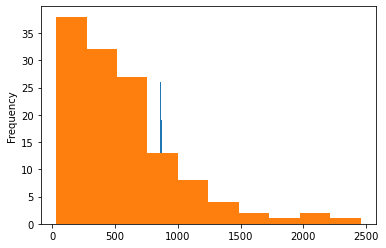

In [135]:
generated_df_class_true.duration.plot(kind='hist')
real_df_class_true.duration.plot(kind='hist')

In [93]:
# cat_cols = df.select_dtypes(include=['category']).columns
# numeric_cols = df.select_dtypes(exclude=['category']).columns
#
# print('categorical columns are:', cat_cols)
# print('numeric columns are:', numeric_cols)

In [85]:
# num_classes = df[label_col].nunique()
#
# df[label_col] = df[label_col].astype('category')
#
# # There's only 1 class, so essentially rename the 'Class' to 'Class_1',
# # which tells weather a sample data is of class 1 or not.
# df = pd.get_dummies(df, columns=[label_col], prefix='class', drop_first=True)
#
# train_sample = df.copy().reset_index(drop=True)
# print(f"df columns: {train_sample.columns}")
#
# # 'Class_1' label
# label_cols = [ i for i in train_sample.columns if 'class_' in i ]
#
# # All columns except 'Class_1'
# data_cols = [ i for i in train_sample.columns if i not in label_cols ]
#
# # Scale down the data, and rename it to 'train_no_label'
# train_sample[data_cols] = train_sample[data_cols].astype(int) / 10 # scale to random noise size, one less thing to learn
#
# # TODO To remove:
# train_no_label = train_sample[data_cols]

In [86]:
models = {'GAN': ['GAN', False, synthesizer.generator]}


In [ ]:
# Setup parameters visualization parameters
seed = 17
test_size = 492 # number of fraud cases
noise_dim = 32

np.random.seed(seed)
z = np.random.normal(size=(test_size, noise_dim))
real = synthesizer.get_data_batch(train=train_sample, batch_size=test_size, seed=seed)
real_samples = pd.DataFrame(real, columns=data_cols+label_cols)
labels = fraud_w_classes['Class']

model_names = ['GAN']
colors = ['deepskyblue','blue']
markers = ['o','^']
class_labels = ['Class 1','Class 2']

col1, col2 = 'V17', 'V10'

base_dir = 'cache/'

# Actual fraud data visualization
model_steps = [ 0, 100, 200]
rows = len(model_steps)
columns = 1 + len(models)

axarr = [[]]*len(model_steps)

fig = plt.figure(figsize=(14,rows*3))

# Go through each of the 3 model_step values -> 0, 100, 200
for model_step_ix, model_step in enumerate(model_steps):        
    axarr[model_step_ix] = plt.subplot(rows, columns, model_step_ix*columns + 1)

    # Plot 'Class 1' and 'Class 2' samples taken from the original data, in a random shuffled fashion
    for group, color, marker, label in zip(real_samples.groupby('Class_1'), colors, markers, class_labels ):
        plt.scatter( group[1][[col1]], group[1][[col2]], 
                         label=label, marker=marker, edgecolors=color, facecolors='none' )
    
    plt.title('Actual Fraud Data')
    plt.ylabel(col2) # Only add y label to left plot
    plt.xlabel(col1)
    xlims, ylims = axarr[model_step_ix].get_xlim(), axarr[model_step_ix].get_ylim()
    
    if model_step_ix == 0: 
        legend = plt.legend()
        legend.get_frame().set_facecolor('white')

    # Go through all the GAN models listed in 'model_names' and defined in 'models'
    for i, model_name in enumerate( model_names[:] ):

        [model_name, with_class, generator_model] = models[model_name]

        generator_model.load_weights( base_dir + '_generator_model_weights_step_'+str(model_step)+'.h5')

        ax = plt.subplot(rows, columns, model_step_ix*columns + 1 + (i+1) )

        if with_class:
            g_z = generator_model.predict([z, labels])
            gen_samples = pd.DataFrame(g_z, columns=data_cols+label_cols)
            for group, color, marker, label in zip( gen_samples.groupby('Class_1'), colors, markers, class_labels ):
                plt.scatter( group[1][[col1]], group[1][[col2]], 
                                 label=label, marker=marker, edgecolors=color, facecolors='none' )
        else:
            g_z = generator_model.predict(z)
            gen_samples = pd.DataFrame(g_z, columns=data_cols+['label'])
            gen_samples.to_csv('../../data/Generated_sample.csv')
            plt.scatter( gen_samples[[col1]], gen_samples[[col2]],
                             label=class_labels[0], marker=markers[0], edgecolors=colors[0], facecolors='none' )
        plt.title(model_name)   
        plt.xlabel(col1)
        ax.set_xlim(xlims), ax.set_ylim(ylims)

plt.suptitle('Comparison of GAN outputs', size=16, fontweight='bold')
plt.tight_layout(rect=[0.075,0,1,0.95])

# Adding text labels for training steps
vpositions = np.array([ i._position.bounds[1] for i in axarr ])
vpositions += ((vpositions[0] - vpositions[1]) * 0.35 )
for model_step_ix, model_step in enumerate( model_steps ):
    fig.text( 0.05, vpositions[model_step_ix], 'training\nstep\n'+str(model_step), ha='center', va='center', size=12)

# if not os.path.exists("./img"):
    # os.makedirs("./img")
# plt.savefig('img/Comparison_of_GAN_outputs.png', dpi=100)

ImportError: ignored

ImportError: ignored

<Figure size 1008x648 with 2 Axes>

# Load Trained Model

In [ ]:
gan_generator = GANDataGenerator(dataset=origin_dataset, model_class=CGAN, trained_model_path=)